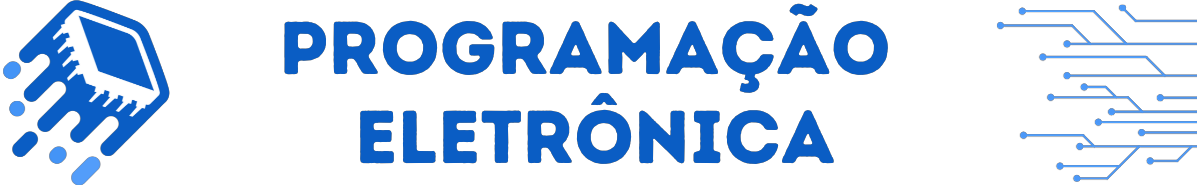

<a href="https://colab.research.google.com/github/programacao-eletronica/dsp_notebooks/blob/master/Gerador%20de%20janelas/Gerador%20de%20janelas.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
<a href="https://github.com/programacao-eletronica/dsp_notebooks/blob/master/Gerador%20de%20janelas/Gerador%20de%20janelas.ipynb" target="_parent"><img align="left" src="https://img.shields.io/badge/GitHub-Open%20source-green?logo=github&amp;style=plastic.svg"></a>

# Gerador de janelas 🪟

Material complementar do curso de [Processamento Digital de Sinais: da amostragem à FFT](https://programacaoeletronica.wordpress.com/cursos-online/)!


** **

Usabilidade: vá até a seção **Geração e visualização da janela** e altere os parâmetros desejados de frequências, amplitude e nome do buffer a ser gerado. Em caso de dúvidas, consulte [ESTE POST](https://programacaoeletronica.wordpress.com/2024/01/13/jupyter-notebook-gerador-de-janelas-em-c/) do blog.

# Definição de funções

In [44]:
# @title Preparação do ambiente

# Limpa todas as variáveis de RAM do ambiente
%reset -f

# Import das libs necessárias
import numpy as np
from numpy.fft import fft
from matplotlib import pyplot as plt
import scipy

In [45]:
# @title Geração de sinais

def generate_window(window_type, buffer_size):
    """
    Gera diferentes janelas para processamento de sinais.

    Parâmetros:
    - window_type: string, tipo de janela ('rectangular', 'hamming', 'hann', 'blackman')
    - buffer_size: int, tamanho do buffer

    Retorna:
    - numpy array, vetor da janela gerada
    """

    if window_type == 'rectangular':
        window = np.ones(buffer_size)
    elif window_type == 'hamming':
        window = np.hamming(buffer_size)
    elif window_type == 'hann':
        window = np.hanning(buffer_size)
    elif window_type == 'blackman':
        window = np.blackman(buffer_size)
    else:
        raise ValueError("Tipo de janela não suportado.")

    return window

In [46]:
# @title Plotagem de dados

# Plotagem de sinal no domínio do tempo
def plot_signal(x, figsize=(12.5, 4)):
    """Plotting three signals

    Args:
        x: Signal
    """
    plt.figure(figsize=figsize)
    plt.plot(x)
    plt.title('Sinal no domínio do tempo/amostras')
    plt.xlabel('n')
    plt.ylabel('x[n]')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [47]:
# @title Salvando buffer como arquivo

def save_buff_to_header(buff, headerName, windowName, dtype='float'):
    """
    Salva uma janela em um arquivo header.

    Parâmetros:
    - buff: dados da janela em float
    - headerName: nome do arquivo *.h
    - windowName: nome da janela, para fins de documentação dentro do header
    - dtype: tipo de dados a ser convertida a janela, podendo ser 'float', 'uint8_t', 'int8_t', 'uint16_t', 'int16_t', 'uint32_t', 'int32_t'

    Retorna:
    - numpy array, vetor da janela gerada
    """
    isUnsigned = False

    if dtype != 'float':
        # Normalizing by the maximum value
        max_value = np.max(np.abs(buff))
        normalized_buffer = (buff / max_value)

        # Converting to the specified data type and range
        if dtype == 'uint8_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 255])
            int_buffer = normalized_buffer.astype(np.uint8)
            isUnsigned = True
            maxOfType = 255
        elif dtype == 'int8_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 255])
            int_buffer = normalized_buffer.astype(np.uint8)
        elif dtype == 'uint16_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 65535])
            int_buffer = normalized_buffer.astype(np.uint16)
            isUnsigned = True
            maxOfType = 65535
        elif dtype == 'int16_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [-32768, 32767])
            int_buffer = normalized_buffer.astype(np.uint16)
        elif dtype == 'uint32_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 4294967295])
            int_buffer = normalized_buffer.astype(np.uint32)
            isUnsigned = True
            maxOfType = 4294967295
        elif dtype == 'int32_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [-2147483648, 2147483647])
            int_buffer = normalized_buffer.astype(np.uint32)
        else:
            raise ValueError("Tipo de dados não suportado.")
    else:
        int_buffer = buff

    buffer_list = int_buffer.tolist()

    # Saving as a text file
    with open('buffer.txt', 'w') as file:
        file.write("""/*******************************************************************************************************/
/**
*   @file         """ + headerName + """.h
*   @addtogroup   PROG_ELET_BUFFS
*   @brief        Buffer de janela do tipo """ + windowName + """
*   @author       Gerador automatico do Programacao Eletronica""")

        if(isUnsigned):
            file.write("""
*   @warning      Buffer do tipo UNSIGNED. Os valores negativos sao representados abaixo de """ + str(int(maxOfType/2)) + """, e os
*                 positivos acima. A exata metade do range (""" + str(int(maxOfType/2)) + """) representa o valor zero.""")

        file.write("""
*
*   @copyright    Wenderson Oliveira - https://programacaoeletronica.wordpress.com
*   @{
********************************************************************************************************/

""")
        file.write('#ifndef WINDOW_' + windowName.upper() + '_H_\n')
        file.write('#define WINDOW_' + windowName.upper() + '_H_\n\n')
        file.write('const ' + dtype + ' window_' + windowName.lower() + '[] = {\n    ')

        # Calculate the maximum width of values for formatting
        max_width = max(len(str(value)) for value in buffer_list)

        # Writing data in lines of 16 elements
        for i, value in enumerate(buffer_list):
            value_str = f'{value:>{max_width}}, '
            file.write(value_str)

            # Adds a line break after every 16 elements
            if (i + 1) % 16 == 0:
                file.write('\n    ')
            else:
                file.write(' ')

        file.write('\n};\n\n')
        file.write("""#endif  /*  WINDOW_""" + windowName.upper() + """_H   */

/** @} FILE */""")

    # Renaming to .h
    import os
    os.rename('buffer.txt', headerName + '.h')

# Geração e visualização da janela

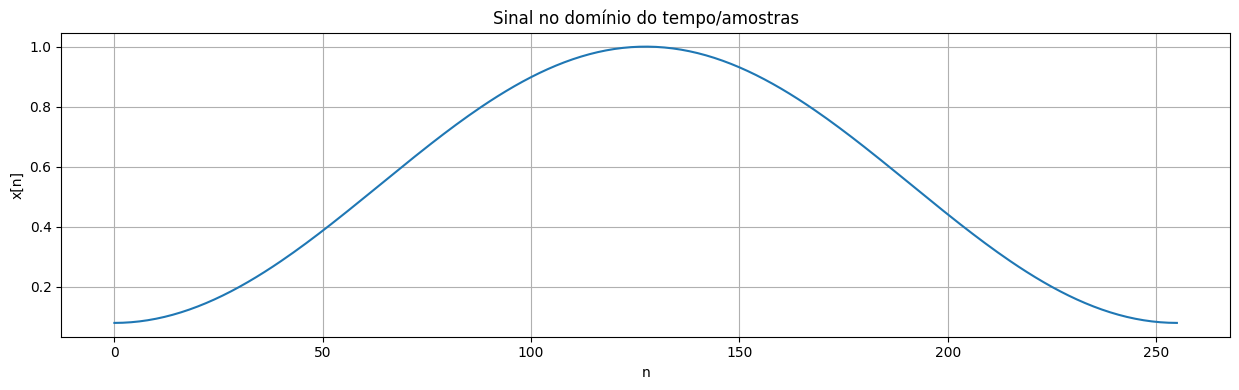

In [50]:
# @title Janela exemplo

# Configurações
windowType = "hamming"
windowSize = 256
bufferType = "int16_t"
headerName = "myWindow"

# Geração automática (não alterar a partir daqui)
window = generate_window(windowType, windowSize)

# Plot no tempo (amostras)
plot_signal(window)

save_buff_to_header(window, headerName, windowType, dtype=bufferType)

Referências:


1. HAYES, Monson H. **Schaum's outline of theory and problems of digital signal processing**. Estados Unidos: McGraw-Hill, 1999. 436 p

** **

image.png

Este notebook é licenciado sob os termos da [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).